# Assembling data.

In [2]:
import numpy as np
import pandas as pd
from astropy.io import fits
import matplotlib.pyplot as plt

Load gaia.

In [8]:
gaia_url = "../data/k2_dr2_1arcsec.fits"

with fits.open(gaia_url) as data:
    gaia = pd.DataFrame(data[1].data, dtype="float64")

Praesepe.

In [41]:
pr = pd.read_csv("../data/praesepe.csv")
print(np.shape(pr))
pr.head()

(652, 42)


,Unnamed: 0,Unnamed: 0.1,source_id,EPIC,ra,dec,G,G_err,bp,rp,...,P,Kpmag,PrCat,PCat,All,2M,Simbad,_RA,_DE,prot
0,1,10833,657785717535594112,211707676,130.226651,16.016838,18.955204,0.010,20.760635,17.508032,...,2,16.79,0,2,All,2M,Simbad,130.226810,16.016886,0.31
1,4,11433,658694566974774656,211725787,128.298544,16.264239,18.501085,0.010,20.369236,17.162775,...,2,18.73,0,2,All,2M,Simbad,128.298692,16.264280,2.06
2,5,11513,657994143708820736,211727975,129.994103,16.296180,18.260777,0.010,19.914898,16.931046,...,2,17.27,0,2,All,2M,Simbad,129.994275,16.296223,0.91
3,7,11580,658736180914476672,211729756,127.646394,16.321452,16.144463,0.002,17.544634,14.969307,...,2,15.46,0,2,All,2M,Simbad,127.646517,16.321543,2.39
4,8,11731,658033215026842368,211734093,129.135515,16.383950,14.624638,0.002,15.622285,13.635796,...,K,14.65,1,2,All,2M,Simbad,129.135678,16.383992,18.22


In [42]:
pr.keys()

Index(['Unnamed: 0', 'Unnamed: 0.1', 'source_id', 'EPIC', 'ra', 'dec', 'G',
       'G_err', 'bp', 'rp', 'parallax', 'parallax_err', 'BP_err', 'RP_err',
       'Name', 'Mass', 'r'mag', 'Kmag', 'Prot1', 'Pw1', 'Q1', 'Clean?', 'Sig',
       'Prot2', 'Pw2', 'Q2', 'MP?', 'SE?', 'Bl?', 'Bin?', 'RawAmp', 'SmAmp',
       'P', 'Kpmag', 'PrCat', 'PCat', 'All', '2M', 'Simbad', '_RA', '_DE',
       'prot'],
      dtype='object')

In [43]:
pr_gaia = pd.merge(pr, gaia, left_on="EPIC", right_on="epic_number", how="left", suffixes=["_rebull", ""])
print(np.shape(pr_gaia), np.shape(gaia), np.shape(pr))
pr_gaia = pr_gaia.drop_duplicates("EPIC")
print(np.shape(pr_gaia))

pr_gaia["period"] = pr_gaia.prot
pr_gaia["bprp"] = pr_gaia.phot_bp_mean_mag - pr_gaia.phot_rp_mean_mag
pr_gaia["age_gyr"] = .7 * np.ones(len(pr_gaia.prot))

pr_gaia.to_csv("praesepe_gaia.csv")

(1402, 140) (296676, 98) (652, 42)
(652, 140)


Text(0, 0.5, 'Prot')

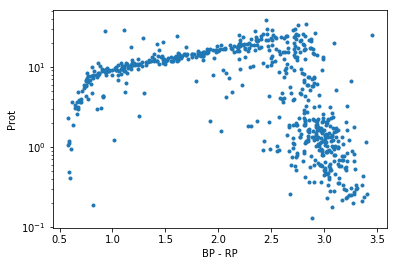

In [44]:
plt.plot(pr_gaia.bprp, pr_gaia.period, ".")
plt.yscale("log")
plt.xlabel("BP - RP")
plt.ylabel("Prot")

In [73]:
def sigma_clip(x, y, yerr, sig=4, iterations=10):

    new_x, new_y, new_yerr = x*1, y*1, yerr*1
    for i in range(iterations):
        A = np.vander(new_x, 6)
        ATA = np.dot(A.T, A)
        pr = np.linalg.solve(ATA, np.dot(A.T, new_y))
        y_pred = np.polyval(pr, new_x)
        sigma = np.std(np.abs(new_y - y_pred))
        outlier_mask = np.abs(new_y - y_pred) < sig*sigma
        new_x, new_y, new_yerr = new_x[outlier_mask], new_y[outlier_mask], new_yerr[outlier_mask]
    
    return new_x, new_y, new_yerr

In [74]:
logbprp, logp, logp_err = np.log10(pr_gaia.bprp.values), np.log10(pr_gaia.prot.values),\
    np.ones_like(pr_gaia.prot.values)*.1

finite_mask = np.isfinite(logbprp) * np.isfinite(logp)
x, y, yerr = logbprp[finite_mask], logp[finite_mask], logp_err[finite_mask]
pr_gaia_clipped = pr_gaia.iloc[finite_mask]

logbprp, logp, logp_err = np.log10(pr_gaia_clipped.bprp.values), np.log10(pr_gaia_clipped.prot.values),\
    np.ones_like(pr_gaia_clipped.prot.values)*.1

In [75]:
hot_mask = logbprp < .43
x_clipped, y_clipped, yerr_clipped = sigma_clip(logbprp[hot_mask], logp[hot_mask], logp_err[hot_mask],
                                                           iterations=20)

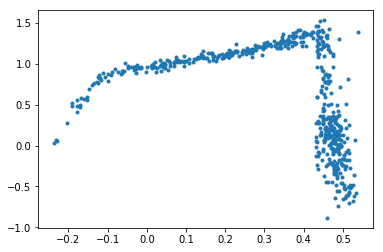

In [60]:
ncool, nhot = len(logbprp[~hot_mask]), len(x_clipped)
p_age = np.log10(650*1e6)
logbprp_clipped = np.concatenate((logbprp[~hot_mask], x_clipped))
logp_clipped = np.concatenate((logp[~hot_mask], y_clipped))
logp_err_clipped = np.concatenate((logp_err[~hot_mask], yerr_clipped))
log_age_clipped = np.concatenate((np.ones(len(logbprp[~hot_mask]))*p_age, np.ones(len(x_clipped))*p_age))

plt.plot(logbprp_clipped, logp_clipped, ".")
# plt.plot(x_clipped, y_clipped, ".", alpha=.5)

In [107]:
praesepe_bprp = 10**logbprp_clipped
praesepe_prot = 10**logp_clipped
praesepe_age = np.ones_like(praesepe_bprp)*.65

from color_conversions import bprp_to_teff
praesepe_teff = bprp_to_teff(praesepe_bprp)

In [108]:
pr_clipped = pd.DataFrame(dict({"bprp": praesepe_bprp, "prot": praesepe_prot, "teff": praesepe_teff}))

In [109]:
print(np.shape(pr_clipped), np.shape(pr_gaia))
pr_clipped_gaia = pd.merge(pr_clipped, pr_gaia, on="bprp", how="left")
print(np.shape(pr_clipped_gaia))

(554, 3) (652, 143)
(554, 145)


Pleaiades.

In [110]:
pl = pd.read_csv("../data/pleiades.csv", skiprows=70, delimiter=";")
pl.head()

,EPIC,RAJ2000,DEJ2000,Vmag,Ksmag,(V-K)0,Prot,Per2,Per3,Per4,Amp,LC,Mm,LPer,H10,vsini,PapIII,PapII,Fig
0,210991540,52.95768,22.84023,,12.75,5.10,0.5749,,,,0.059,2,best,0.57,0,,1,1,Fig
1,211016313,53.03274,23.23265,,12.25,5.05,0.3193,,,,0.056,1,best,,0,,1,1,Fig
2,211029135,53.15753,23.43315,,13.06,5.76,0.2860,,,,0.032,4,best,,0,,1,1,Fig
3,211037397,53.17625,23.56679,,12.54,5.58,0.4990,0.3167,,,0.023,1,best,,0,,1,1,Fig
4,210946764,53.27427,22.13423,11.36,9.43,1.82,5.7660,,,,0.011,4,best,,0,,1,1,Fig


In [111]:
pl_gaia = pd.merge(pl, gaia, left_on="EPIC", right_on="epic_number", how="left", suffixes=["_douglas", ""])
print(np.shape(pl_gaia), np.shape(gaia), np.shape(pl))
pl_gaia = pl_gaia.drop_duplicates("EPIC")
print(np.shape(pl_gaia))

pl_gaia["period"] = pl_gaia.Prot
pl_gaia["bprp"] = pl_gaia.phot_bp_mean_mag - pl_gaia.phot_rp_mean_mag
pl_gaia["age_gyr"] = .15 * np.ones(len(pl_gaia.period))

pl_gaia.to_csv("pleiades_gaia.csv")

(763, 117) (296676, 98) (759, 19)
(759, 117)


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in less
  


Text(0, 0.5, 'Prot')

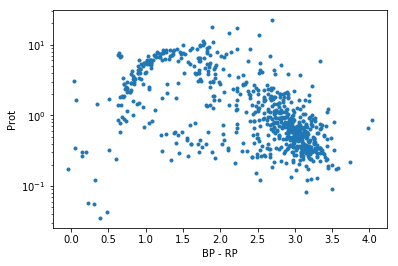

In [112]:
plt.plot(pl_gaia.bprp, pl_gaia.period, ".")
m = (pl_gaia.period.values < .5) * (pl_gaia.bprp.values < 1)
plt.yscale("log")
plt.xlabel("BP - RP")
plt.ylabel("Prot")

Hyades.

In [113]:
hy = pd.read_csv("../data/hyades_single.csv")
hy.head()

,Unnamed: 0,source_id,EPIC,ra,dec,G,G_err,bp,bp_err,rp,...,K2Per,K2Pw,Amp,Ng,Bl,Lit,Binary,RA_deg,DE_deg,prot
0,0,38329666836450304,210365286,59.560424,12.627971,15.111156,0.002,17.014067,0.20,13.799521,...,0.8686,0.3102,0.002825,Y,Y,0,NaN,59.559583,12.628000,0.8686
1,1,3304478125929665152,210371851,62.777381,12.796658,16.540540,0.002,18.953999,0.20,15.119150,...,0.8968,0.1551,0.006550,N,N,0,NaN,62.776667,12.796722,0.8968
2,5,3311464182294287104,210451321,64.481996,14.546192,13.771758,0.002,15.280359,0.01,12.565312,...,10.1182,0.8654,0.009591,Y,N,0,NaN,64.481250,14.546250,10.1182
3,6,3311102820926310784,210459199,65.396680,14.695157,14.314161,0.002,15.956227,0.01,13.073628,...,3.6375,0.4464,0.019108,Y,M,0,NaN,65.395833,14.695222,3.6375
4,7,3311906770084019712,210470484,64.367727,14.900986,13.276046,0.002,14.700910,0.01,12.105038,...,2.3788,0.4353,0.010794,Y,Y,0,NaN,64.367083,14.901056,2.3788


In [114]:
hy_gaia = pd.merge(hy, gaia, left_on="EPIC", right_on="epic_number", how="left", suffixes=["_douglas", ""])
print(np.shape(hy_gaia), np.shape(gaia), np.shape(hy))
hy_gaia = hy_gaia.drop_duplicates("EPIC")
print(np.shape(hy_gaia))

hy_gaia["period"] = hy_gaia.K2Per
hy_gaia["bprp"] = hy_gaia.phot_bp_mean_mag - hy_gaia.phot_rp_mean_mag
hy_gaia["age_gyr"] = .700 * np.ones(len(hy_gaia.period))

hy_gaia.to_csv("hyades_gaia.csv")

(28, 137) (296676, 98) (25, 39)
(25, 137)


Text(0, 0.5, 'Prot')

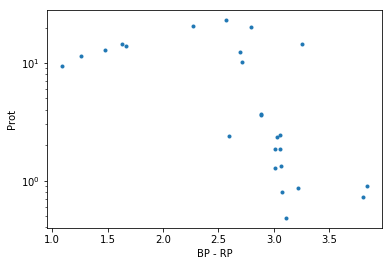

In [115]:
plt.plot(hy_gaia.bprp, hy_gaia.period, ".")
plt.yscale("log")
plt.xlabel("BP - RP")
plt.ylabel("Prot")

NGC 6811.

In [116]:
n11_gaia = pd.read_csv("../data/NGC6811.csv")
    
n11_gaia["period"] = n11_gaia.Per
n11_gaia["bprp"] = n11_gaia.phot_bp_mean_mag - n11_gaia.phot_rp_mean_mag
n11_gaia["age_gyr"] = 1.1 * np.ones(len(n11_gaia.period))

n11_gaia.to_csv("NGC6811_gaia.csv")

Text(0, 0.5, 'Prot')

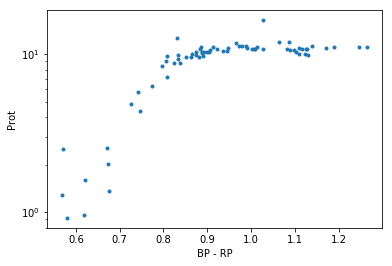

In [117]:
plt.plot(n11_gaia.bprp, n11_gaia.period, ".")
plt.yscale("log")
plt.xlabel("BP - RP")
plt.ylabel("Prot")

NGC 6819.

In [118]:
n19_gaia = pd.read_csv("../data/ngc6819_err.csv")

n19_gaia["period"] = n19_gaia.prot
n19_gaia["period_err"] = n19_gaia.prot_err
n19_gaia["bprp"] = n19_gaia.bp_dered - n19_gaia.rp_dered
n19_gaia["age_gyr"] = 2.5 * np.ones(len(n19_gaia.period))

n19_gaia.to_csv("NGC6819_gaia.csv")

Text(0, 0.5, 'Prot')

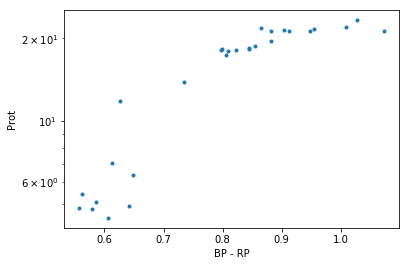

In [119]:
plt.plot(n19_gaia.bprp, n19_gaia.period, ".")
plt.yscale("log")
plt.xlabel("BP - RP")
plt.ylabel("Prot")

In [120]:
df = pd.concat([pr_clipped_gaia, pl_gaia, hy_gaia, n11_gaia, n19_gaia])
# df = pd.concat([n11_gaia, n19_gaia])

np.shape(df)
df.to_csv("clusters.csv")

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in greater
  """Entry point for launching an IPython kernel.


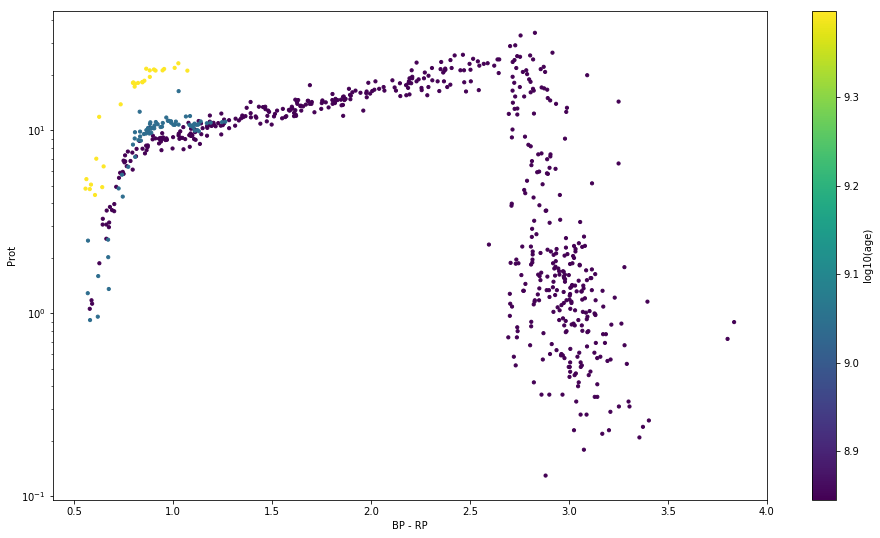

In [121]:
m = df.age_gyr.values > .5
plt.figure(figsize=(16, 9))
plt.scatter(df.bprp[m], df.period[m], c=np.log10(1e9*df.age_gyr[m]), s=10)
plt.yscale("log")
plt.xlabel("BP - RP")
plt.ylabel("Prot")
plt.colorbar(label="log10(age)")

field stars

In [122]:
# Alpha Cen B, 94 Aqr B, 61 Cyg A, 61 Cyg B, Sun
f_teff = np.array([5178, 5168, 4374, 4044, 4577])
f_logg = np.array([4.56, 4.59, np.nan, np.nan, 4.44])
f_feh = np.array([0.23, 0.22, -0.33, -0.33, 0.])
f_age = np.array([6., 6.2, 6., 6., 4.56])
f_age_err = np.array([1., 0.4, 1., 1., .001])
f_prot = np.array([37., 38.9, 35.3, 37.8, 26.])
f_prot_err = np.array([1.5, 1.9, .05*35.3, .05*37.8, 1.])
f_bprp = np.array([1.026, 1.030, 1.441, 1.719, .82])

field = pd.DataFrame(dict({"teff": f_teff,
                           "feh": f_feh,
                           "age": f_age,
                           "age_err": f_age_err,
                           "prot": f_prot,
                           "prot_err": f_prot_err,
                            }))

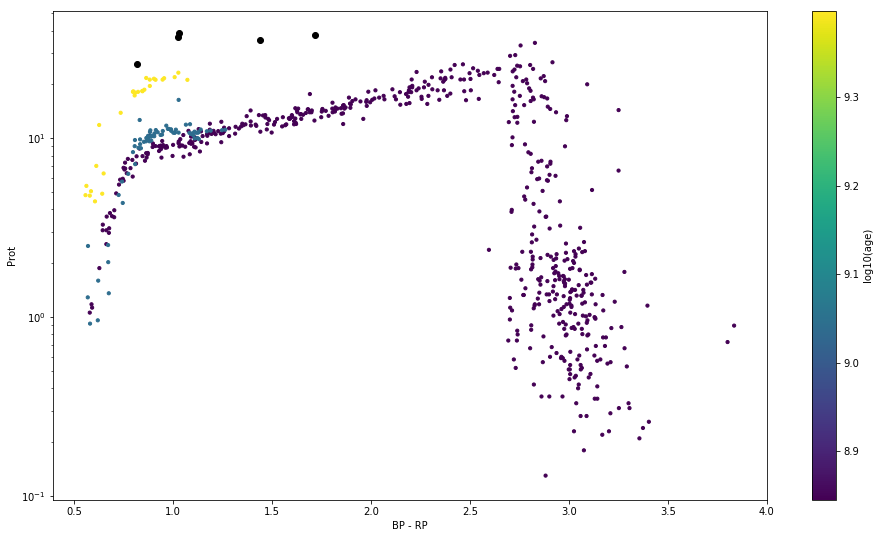

In [123]:
plt.figure(figsize=(16, 9))
plt.scatter(df.bprp[m], df.period[m], c=np.log10(1e9*df.age_gyr[m]), s=10)
plt.plot(f_bprp, f_prot, "ko")
plt.yscale("log")
plt.xlabel("BP - RP")
plt.ylabel("Prot")
plt.colorbar(label="log10(age)")

In [124]:
field.to_csv("field_stars.csv")

In [125]:
clean = df.iloc[m]
clean.to_csv("clean_clusters.csv")

(7100, 2900)

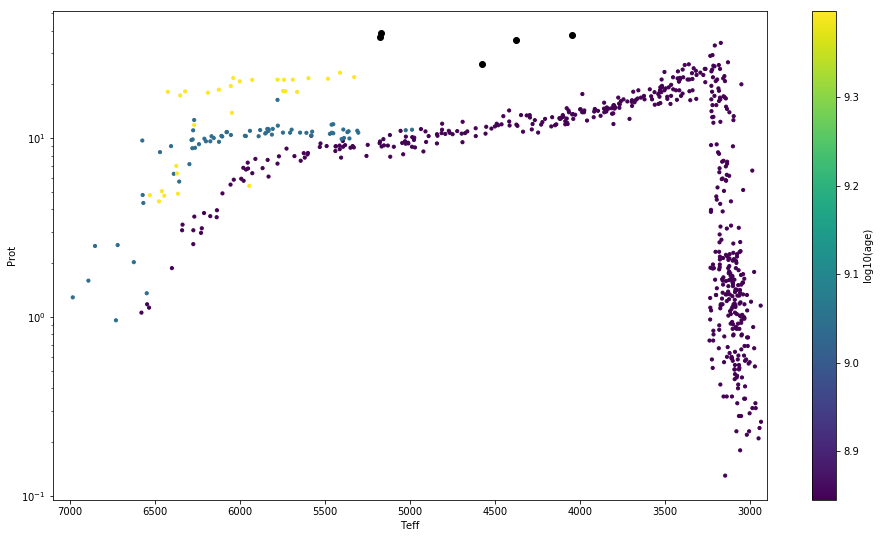

In [127]:
plt.figure(figsize=(16, 9))
plt.scatter(df.teff[m], df.period[m], c=np.log10(1e9*df.age_gyr[m]), s=10)
plt.plot(f_teff, f_prot, "ko")
plt.yscale("log")
plt.xlabel("Teff")
plt.ylabel("Prot")
plt.colorbar(label="log10(age)")
plt.xlim(7100, 2900)